# Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, Masking, Bidirectional, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import matplotlib.pyplot as plt

import os

import datetime as dt

import pandas as pd

import sklearn 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import numpy as np

import pickle

# User-defined functions

In [2]:
# function to decode the target
def conv(x):
    my_dict = {0: 'business',
               1: 'entertainment',
               2: 'politics',
               3: 'sport',
               4: 'tech'}
  
    return my_dict[x]

# Statics

In [3]:
# path for the training logs
time_stamp = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
LOG_PATH = os.path.join(os.getcwd(), 'logs', time_stamp)

# Load data

In [4]:
DATA_PATH = 'https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv'
df = pd.read_csv(DATA_PATH)
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


## general infos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


## number of text categories

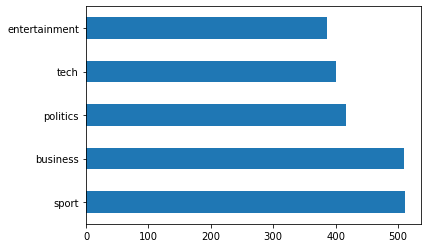

In [6]:
df['category'].value_counts().plot.barh()
plt.show()

# Data wrangling

## handle duplicates

### view how much duplicates

In [7]:
df.duplicated().sum()

99

### view the duplicates itself

In [15]:
# df[df.duplicated()]

,category,text
85,politics,hague given up his pm ambition former conser...
301,politics,fox attacks blair s tory lies tony blair lie...
496,tech,microsoft gets the blogging bug software giant...
543,business,economy strong in election year uk businesse...
582,entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
2206,politics,kennedy questions trust of blair lib dem leade...
2207,tech,california sets fines for spyware the makers o...
2213,tech,progress on new internet domains by early 2005...
2215,tech,junk e-mails on relentless rise spam traffic i...


### drop/remove duplicates

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
df = df.reset_index(drop=True)
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,business,cars pull down us retail figures us retail sal...
2122,politics,kilroy unveils immigration policy ex-chatshow ...
2123,entertainment,rem announce new glasgow concert us band rem h...
2124,politics,how political squabbles snowball it s become c...


## remove HTML tags (if any)

In [10]:
df['text'] = df['text'].str.replace('<.*?>', ' ')
df

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_13592\796569887.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('<.*?>', ' ')


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,business,cars pull down us retail figures us retail sal...
2122,politics,kilroy unveils immigration policy ex-chatshow ...
2123,entertainment,rem announce new glasgow concert us band rem h...
2124,politics,how political squabbles snowball it s become c...


## remove non-aphabetical characters

In [11]:
df['text'] = df['text'].str.replace('[^a-zA-Z]', ' ')
df

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_13592\4192767771.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^a-zA-Z]', ' ')


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,business,cars pull down us retail figures us retail sal...
2122,politics,kilroy unveils immigration policy ex chatshow ...
2123,entertainment,rem announce new glasgow concert us band rem h...
2124,politics,how political squabbles snowball it s become c...


## lowercase all reviews

In [12]:
df['text'] = df['text'].str.lower()
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,business,cars pull down us retail figures us retail sal...
2122,politics,kilroy unveils immigration policy ex chatshow ...
2123,entertainment,rem announce new glasgow concert us band rem h...
2124,politics,how political squabbles snowball it s become c...


# Creating features

## create features dataframe

In [13]:
texts = df['text']
texts

0       tv future in the hands of viewers with home th...
1       worldcom boss  left books alone  former worldc...
2       tigers wary of farrell  gamble  leicester say ...
3       yeading face newcastle in fa cup premiership s...
4       ocean s twelve raids box office ocean s twelve...
                              ...                        
2121    cars pull down us retail figures us retail sal...
2122    kilroy unveils immigration policy ex chatshow ...
2123    rem announce new glasgow concert us band rem h...
2124    how political squabbles snowball it s become c...
2125    souness delight at euro progress boss graeme s...
Name: text, Length: 2126, dtype: object

## find the number of words in each text

In [14]:
texts.apply(lambda x: len(x.split()))

0       744
1       296
2       247
3       345
4       261
       ... 
2121    273
2122    155
2123    295
2124    846
2125    222
Name: text, Length: 2126, dtype: int64

## boxplot of the number of words

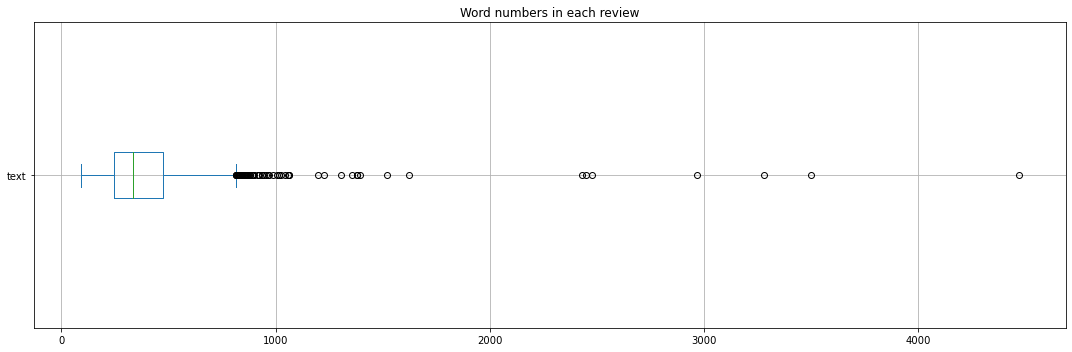

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
texts.apply(lambda x: len(x.split())).plot.box(ax=ax, 
                                               vert=False, 
                                               title='Word numbers in each review', 
                                               grid=True)
plt.tight_layout()
plt.show()

## find the median/mean/mode/max/min number of words for the whole given texts

In [16]:
median = texts.apply(lambda x: len(x.split())).median()
mean = texts.apply(lambda x: len(x.split())).mean()
mode = texts.apply(lambda x: len(x.split())).mode()
max_words = texts.apply(lambda x: len(x.split())).max()
min_words = texts.apply(lambda x: len(x.split())).min()

print(f'Median: {median}\nMean: {mean}\nMode: {mode.values[0]}\nMax: {max_words}\nMin: {min_words}')

Median: 333.0
Mean: 386.3612417685795
Mode: 219
Max: 4469
Min: 90


### because there are outliers in the above boxplots, we might want to consider using the median number of words as max padding length

## tokenizing

### create tokenizer object and fit to the given texts

In [17]:
vocab_size = 10000
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)

### save the fitted tokenizer

In [43]:
TOKENIZER_PATH = os.path.join(os.getcwd(), 'model', 'tokenizer.pkl')

with open(TOKENIZER_PATH, 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)

### the word index

In [18]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'and': 5,
 'a': 6,
 'in': 7,
 's': 8,
 'for': 9,
 'is': 10,
 'that': 11,
 'it': 12,
 'on': 13,
 'said': 14,
 'was': 15,
 'he': 16,
 'be': 17,
 'with': 18,
 'has': 19,
 'as': 20,
 'have': 21,
 'at': 22,
 'by': 23,
 'but': 24,
 'will': 25,
 'are': 26,
 'i': 27,
 'from': 28,
 'not': 29,
 'his': 30,
 'they': 31,
 'we': 32,
 'mr': 33,
 'an': 34,
 'this': 35,
 'had': 36,
 'would': 37,
 'which': 38,
 'been': 39,
 'their': 40,
 'year': 41,
 'more': 42,
 'up': 43,
 'its': 44,
 'were': 45,
 'also': 46,
 'who': 47,
 'people': 48,
 'us': 49,
 'new': 50,
 'm': 51,
 'one': 52,
 'there': 53,
 'about': 54,
 'after': 55,
 'out': 56,
 'can': 57,
 'than': 58,
 'or': 59,
 'all': 60,
 'if': 61,
 'you': 62,
 'could': 63,
 'over': 64,
 'last': 65,
 'first': 66,
 't': 67,
 'when': 68,
 'time': 69,
 'two': 70,
 'world': 71,
 'government': 72,
 'now': 73,
 'into': 74,
 'so': 75,
 'what': 76,
 'some': 77,
 'other': 78,
 'uk': 79,
 'she': 80,
 'years': 81,
 'no': 82,
 

### tokenize the given texts

In [19]:
texts_tokenized = tokenizer.texts_to_sequences(texts)
# len(reviews_tokenized[0])

## padding the tokenized array

In [22]:
# max length of the padded array (usually depends on the median/mean/mode/min/max number of words per texts)
# we choose median because there are outliers 
max_len = int(texts.apply(lambda x: len(x.split())).median())

texts_tokenized_padded = pad_sequences(texts_tokenized, 
                                       maxlen=max_len, 
                                       padding='post', 
                                       truncating='post')
texts_tokenized_padded.shape

(2126, 333)

In [23]:
texts_tokenized_padded

array([[ 173,  253,    7, ...,   42, 5193,  402],
       [1598,  659,  315, ...,    0,    0,    0],
       [4753, 7101,    4, ...,    0,    0,    0],
       ...,
       [5739, 2184,   50, ...,    0,    0,    0],
       [ 130,  477,    1, ...,    2, 5135, 7564],
       [2438, 7542,   22, ...,    0,    0,    0]])

# Creating target

## encode the category using OneHotEncoder

In [24]:
ohe = OneHotEncoder(sparse=False)
category_encoded = ohe.fit_transform(df[['category']])

category_encoded.shape

(2126, 5)

In [25]:
category_encoded

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

## categories observed during fitting

In [26]:
ohe.categories_

[array(['business', 'entertainment', 'politics', 'sport', 'tech'],
       dtype=object)]

## save the encoder

In [59]:
OHE_PATH = os.path.join(os.getcwd(), 'model', 'ohe.pkl')

with open(OHE_PATH, 'wb') as file:
    pickle.dump(ohe, file)

# Train-test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(texts_tokenized_padded, 
                                                    category_encoded, 
                                                    test_size=0.2, 
                                                    random_state=190922)

# Deep Learning

## create network layers

In [30]:
input_shape = X_train.shape[-1]
output_shape = y_train.shape[-1]
embedding_dim = 64

input_1 = Input(shape=(input_shape,))

hl_0 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_1)
hl_1 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(hl_0)
hl_2 = Dropout(0.4)(hl_1)
hl_3 = LSTM(128)(hl_2)
hl_4 = Dropout(0.4)(hl_3)
hl_5 = Dense(128, activation='relu')(hl_4)
hl_6 = Dropout(0.4)(hl_5)       

output_1 = Dense(output_shape, activation='softmax')(hl_6)

## create model

In [31]:
model = Model(inputs=input_1, outputs=output_1)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 333)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 333, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 333, 128)          66048     
_________________________________________________________________
dropout (Dropout)            (None, 333, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)              

## plot model networks

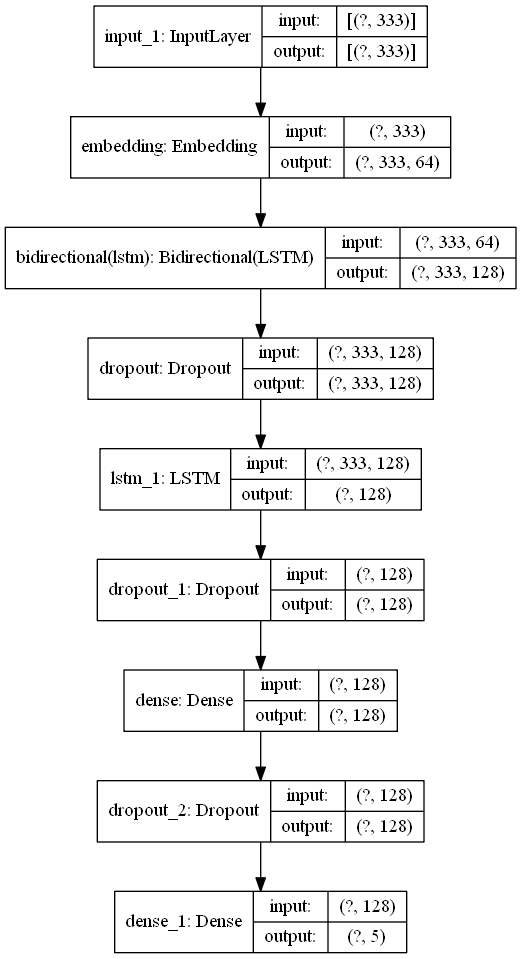

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True)

## compile model

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

## callbacks

In [34]:
tensorboard_callback = TensorBoard(log_dir=LOG_PATH)
early_stopping_callback = EarlyStopping(monitor='loss', patience=3, verbose='min')

# Model training

## train model and save History object

In [37]:
model_hist = model.fit(X_train, 
                       y_train, 
                       epochs=10,
                       batch_size=170,
                       validation_data=(X_test, y_test),
                       callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/10
10/10 [==============================] - 31s 3s/step - loss: 1.5373 - acc: 0.2629 - val_loss: 1.4808 - val_acc: 0.3052
Epoch 2/10
10/10 [==============================] - 31s 3s/step - loss: 1.4683 - acc: 0.2929 - val_loss: 1.2753 - val_acc: 0.3756
Epoch 3/10
10/10 [==============================] - 29s 3s/step - loss: 1.3281 - acc: 0.3718 - val_loss: 1.3398 - val_acc: 0.3286
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 1.2980 - acc: 0.3494 - val_loss: 1.2523 - val_acc: 0.3873
Epoch 5/10
10/10 [==============================] - 28s 3s/step - loss: 1.2368 - acc: 0.3806 - val_loss: 1.1594 - val_acc: 0.3756
Epoch 6/10
10/10 [==============================] - 27s 3s/step - loss: 1.1720 - acc: 0.4065 - val_loss: 1.2769 - val_acc: 0.4061
Epoch 7/10
10/10 [==============================] - 28s 3s/step - loss: 1.1746 - acc: 0.4076 - val_loss: 1.2844 - val_acc: 0.3592
Epoch 8/10
10/10 [==============================] - 27s 3s/step - loss: 1.1066 - acc: 0.41

## plot loss and metrics against epochs

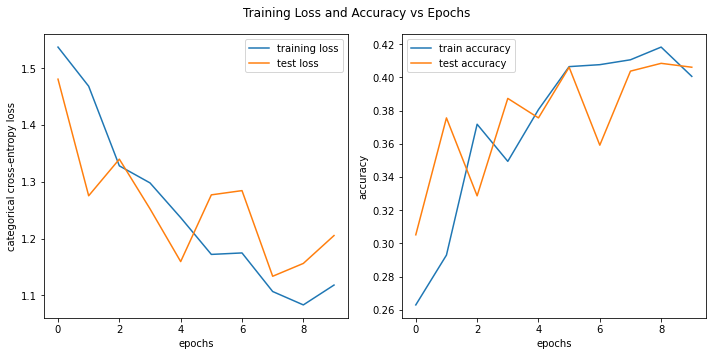

In [38]:
train_loss = model_hist.history['loss']
train_metric = model_hist.history['acc']
test_loss = model_hist.history['val_loss']
test_metric = model_hist.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training Loss and Accuracy vs Epochs')

ax[0].plot(train_loss, label='training loss')
ax[0].plot(test_loss, label='test loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('categorical cross-entropy loss')
ax[0].legend()

ax[1].plot(train_metric, label='train accuracy')
ax[1].plot(test_metric, label='test accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

# Model evaluation

In [39]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 1s 91ms/step - loss: 1.2053 - acc: 0.4061


[1.2052500247955322, 0.4061032831668854]

# Save the model

In [36]:
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'model.h5')
model.save(MODEL_PATH)

# Predictions

## generate decoded predictions from the test data

In [40]:
# predict output
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# vectorize conv(x) function
conv = np.vectorize(conv)

# convert to appropriate categories
y_pred_decoded = conv(y_pred).astype(object)
y_pred_decoded

array(['sport', 'politics', 'sport', 'sport', 'tech', 'tech', 'tech',
       'sport', 'sport', 'tech', 'sport', 'sport', 'tech', 'tech',
       'sport', 'sport', 'sport', 'tech', 'tech', 'sport', 'sport',
       'sport', 'tech', 'sport', 'sport', 'sport', 'sport', 'sport',
       'tech', 'sport', 'tech', 'politics', 'politics', 'sport', 'tech',
       'politics', 'tech', 'tech', 'tech', 'sport', 'sport', 'tech',
       'tech', 'sport', 'politics', 'tech', 'sport', 'tech', 'sport',
       'tech', 'tech', 'tech', 'tech', 'sport', 'sport', 'tech', 'tech',
       'sport', 'sport', 'sport', 'tech', 'sport', 'tech', 'tech',
       'sport', 'politics', 'sport', 'sport', 'tech', 'tech', 'politics',
       'sport', 'politics', 'tech', 'tech', 'politics', 'sport', 'sport',
       'sport', 'tech', 'politics', 'tech', 'tech', 'sport', 'sport',
       'sport', 'tech', 'tech', 'sport', 'sport', 'sport', 'sport',
       'sport', 'sport', 'sport', 'sport', 'sport', 'sport', 'tech',
       'sport', 'sp

## decode test data from one-hot encoded form into original categories

In [41]:
y_test_decoded = ohe.inverse_transform(y_test)
y_test_decoded = y_test_decoded[:,0]
y_test_decoded

array(['sport', 'politics', 'entertainment', 'tech', 'tech',
       'entertainment', 'business', 'business', 'business', 'business',
       'politics', 'business', 'business', 'business', 'sport', 'sport',
       'sport', 'tech', 'tech', 'business', 'business', 'entertainment',
       'politics', 'business', 'business', 'sport', 'sport', 'sport',
       'entertainment', 'business', 'tech', 'politics', 'politics',
       'sport', 'tech', 'tech', 'business', 'politics', 'tech', 'sport',
       'business', 'politics', 'business', 'business', 'politics',
       'politics', 'business', 'tech', 'sport', 'entertainment', 'tech',
       'business', 'politics', 'business', 'sport', 'politics',
       'politics', 'sport', 'business', 'sport', 'entertainment',
       'business', 'tech', 'politics', 'sport', 'tech', 'business',
       'entertainment', 'politics', 'politics', 'tech', 'entertainment',
       'politics', 'politics', 'tech', 'politics', 'sport',
       'entertainment', 'sport', 'polit

# Model performance key metrics

## classification report

In [42]:
report = classification_report(y_test_decoded, y_pred_decoded)
print(report)

               precision    recall  f1-score   support

     business       0.00      0.00      0.00       104
entertainment       0.00      0.00      0.00        73
     politics       0.61      0.32      0.42        84
        sport       0.40      0.99      0.57        98
         tech       0.36      0.73      0.48        67

     accuracy                           0.41       426
    macro avg       0.27      0.41      0.29       426
 weighted avg       0.27      0.41      0.29       426



c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## confusion matrix plot

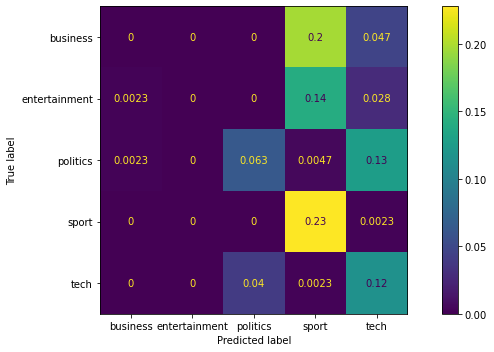

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test_decoded, 
                                        y_pred_decoded, 
                                        normalize='all', 
                                        ax=ax)
plt.tight_layout()
plt.show()

# Custom input testing

In [49]:
my_review = input('Give your review: ')

input_review = pd.Series([my_review], name='review')
input_review = input_review.str.replace('<.*?>', ' ')
input_review = input_review.str.replace('[^a-zA-Z]', ' ')
input_review = input_review.str.lower()

input_review_tokenized = tokenizer.texts_to_sequences(input_review)

max_len = int(texts.apply(lambda x: len(x.split())).median()) # this value is 333 for now
input_review_tokenized_padded = pad_sequences(input_review_tokenized, maxlen=max_len, padding='post', truncating='post')

predicted_sentiment = model.predict(input_review_tokenized_padded)
predicted_sentiment = np.argmax(predicted_sentiment, axis=1)
predicted_sentiment_decoded = conv(predicted_sentiment).astype(object)

print(f'Your review have {predicted_sentiment_decoded[0]} sentiment')

Your review have tech sentiment


C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_17228\283986300.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  input_review = input_review.str.replace('<.*?>', ' ')
C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_17228\283986300.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  input_review = input_review.str.replace('[^a-zA-Z]', ' ')
